# Scraping Popular Youtube videos by category

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from time import sleep
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd

#options.add_argument("--headless")  # Run Chrome in headless mode (no UI)
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

def get_youtube_titles(search_query):
    try:
        # Open YouTube
        driver.get("https://www.youtube.com")
        sleep(2)

        df = pd.DataFrame()

        for category in search_query:

            #print(category)

            # Find the search bar and enter query
            search_box = driver.find_element(By.NAME, "search_query")
            search_box.clear()
            search_box.send_keys(category)
            search_box.send_keys(Keys.RETURN)
            sleep(5)

            video_elements = driver.find_elements(By.XPATH, '//ytd-video-renderer')

            results = []

            cnt = 0
            while cnt < 50:
                sleep(2)
                video_elements = driver.find_elements(By.XPATH, '//ytd-video-renderer')
                for video in video_elements[cnt*2:cnt*2 + 2]:  
                    try:
                        title = video.find_element(By.XPATH, './/a[@id="video-title"]').text
                    except:
                        title = "N/A"

                    try:
                        thumbnail_element = (video
                                            .find_element(By.XPATH, './/a[@id="thumbnail"]//yt-image'))

                        driver.execute_script("arguments[0].scrollIntoView();", thumbnail_element)
                        sleep(1)
                        #thumbnail = driver.execute_script("return arguments[0].getAttribute('src');", thumbnail_element)
                        thumbnail = thumbnail_element.find_element(By.TAG_NAME, "img").get_attribute('src')
                    except:
                        thumbnail = "N/A"

                    try:
                        views = video.find_element(By.XPATH, './/span[contains(text(), "views")]').text
                    except:
                        views = "N/A"

                    try:
                        date = video.find_element(By.XPATH, './/span[contains(text(), "ago")]').text
                    except:
                        date = "N/A"

                    try:
                        href = video.find_element(By.XPATH, './/a[@id="thumbnail"]').get_attribute("href")
                        shorts =  "shorts" in href
                    except:
                        shorts = "N/A"

                    results.append({"title": title, "thumbnail": thumbnail, "views": views, 
                                    "date": date, "category": category, "shorts": shorts})
                    cnt += 1

            pd.DataFrame(results).to_csv(f"{category}.csv")

            df = pd.concat([df, pd.DataFrame(results)], axis = 0)

    finally:
        driver.quit()

    return df

search_term = ["Music", "Movies", "Books", "Games", "Sport", "Travel", 
               "Technology", "Health", "Food", "Science", "History",
               "Fashion", "Art", "Business", "Education", "Photography"]

df = get_youtube_titles(search_term)

# Data Processing 

In [77]:
def convert_views_to_int(views):
    '''
    Convert views from string to integer
    '''
    try:
        views = views.split(" ")[0]
        if not("K" in views or "M" in views):
            return int(views)
        multiplier = 1000 if "K" in views else 1000000 if "M" in views else 1
        return int(float(views[:-1]) * multiplier)
    except:
        return None
    
def convert_date_to_int(date):
    '''
    Convert time from string to number of hours
    '''
    try:
        date_split = date.split(" ")[:-1]
        if date_split[-1] == "years" or date_split[-1] == "year":
            return int(date_split[-2]) * 365 * 24
        elif date_split[-1].strip() == "months" or date_split[-1] == "month":
            return int(date_split[-2]) * 30 * 24
        elif date_split[-1] == "weeks" or date_split[-1] == "week":
            return int(date_split[-2]) * 7 * 24
        elif date_split[-1] == "days" or date_split[-1] == "day":
            return int(date_split[-2]) * 24
        elif date_split[-1] == "hours" or date_split[-1] == "hour":
            return int(date_split[-2])
        elif date_split[-1] == "minutes" or date_split[-1] == "minute":
            return int(date_split[-2]) / 60
        elif date_split[-1] == "seconds" or date_split[-1] == "second":
            return int(date_split[-2]) / 3600
        else:
            return None
    except:
        return None

# Combining all the dataframes
search_term = ["Music", "Movies", "Books", "Games", "Sport", "Travel", 
               "Technology", "Health", "Food", "Science", "History",
               "Fashion", "Art", "Business", "Education", "Photography"]

df = pd.DataFrame()
for cat in search_term:
    df = pd.concat([df, pd.read_csv(f"{cat}.csv")], axis = 0) 

# Convert views and time to numerical type and drop unnecessary columns
df["views"] = df["views"].apply(convert_views_to_int)
df["time"] = df["date"].apply(convert_date_to_int)
df = df.reset_index(drop = True)
df = df.drop(columns = ["Unnamed: 0"])

# Rearrange columns
columns = ["title", "views", "time", "category", "shorts", "thumbnail", "date"]
df = df[columns]
df

,title,views,time,category,shorts,thumbnail,date
0,"Lady Gaga, Bruno Mars - Die With A Smile (Offi...",686000000.0,3600.0,Music,False,https://i.ytimg.com/vi/kPa7bsKwL-c/hq720.jpg?s...,5 months ago
1,Top hits 2024 playlist ~ Trending music 2024 ~...,45000000.0,4320.0,Music,False,https://i.ytimg.com/vi/U0ZoqmyGJo8/hq720.jpg?s...,6 months ago
2,"Beautiful Relaxing Music - Stop Overthinking, ...",5900000.0,2880.0,Music,False,https://i.ytimg.com/vi/z-qigE1ym40/hq720.jpg?s...,Streamed 4 months ago
3,Gigi Perez - Sailor Song (Lyrics),31000000.0,2160.0,Music,False,https://i.ytimg.com/vi/KZGWfHdfWQs/hq720.jpg?s...,3 months ago
4,Kendrick Lamar's Apple Music Super Bowl Halfti...,51000000.0,72.0,Music,False,https://i.ytimg.com/vi/KDorKy-13ak/hq720.jpg?s...,3 days ago
...,...,...,...,...,...,...,...
799,Ed Sheeran - Photograph (Official Lyric Video),10000000.0,5040.0,Photography,False,https://i.ytimg.com/vi/KKQl-pIRQMY/hq720.jpg?s...,7 months ago
800,"$20,000 camera vs iPhone 13 Pro Max! 📸📱#photo ...",14000000.0,17520.0,Photography,True,https://i.ytimg.com/vi/xaNt6YOFhjg/hq720_2.jpg...,2 years ago
801,Happy Diwali 🎊 Photography 📸💯👈 #shorts #photog...,4700000.0,2160.0,Photography,True,https://i.ytimg.com/vi/SuHqZWne0oM/hq720.jpg?s...,3 months ago
802,Random shots of the beautiful people #streetph...,59000000.0,8760.0,Photography,True,https://i.ytimg.com/vi/AybaCoAZdSY/hq720_2.jpg...,1 year ago


# Visualisation

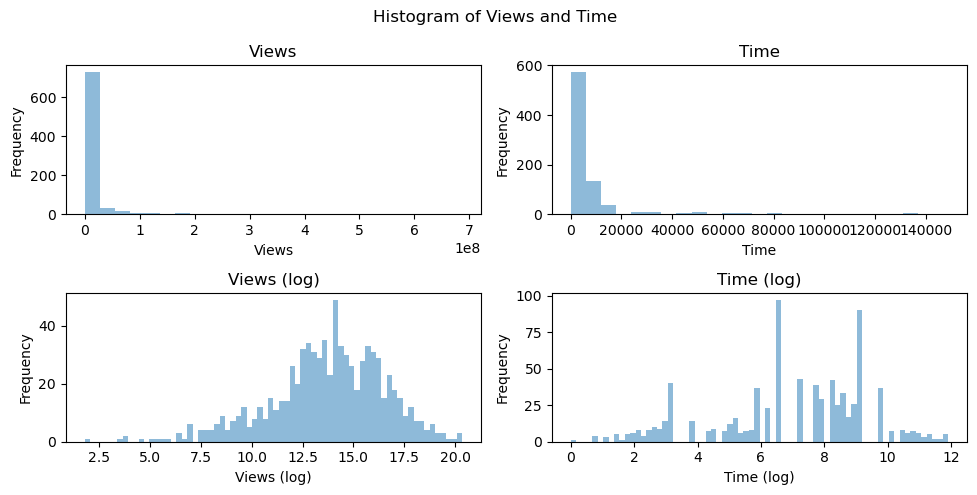

In [105]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2,2, figsize = (10, 5))
fig.suptitle("Histogram of Views and Time")

vis = ["views", "time", "views", "time"]
name = ["Views", "Time", "Views (log)", "Time (log)"]
for i in range(4):
    if i // 2 == 0:
        ax[i//2][i%2].hist(df[vis[i]], bins = 25, alpha = 0.5, label = name[i])
    else:
        ax[i//2][i%2].hist(np.log(df[vis[i]]), bins = 70, alpha = 0.5, label = name[i])
    
    ax[i//2][i%2].set_xlabel(name[i])
    ax[i//2][i%2].set_ylabel("Frequency")
    ax[i//2][i%2].set_title(name[i])

plt.tight_layout()
plt.show()